In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [49]:
mesh=31
y_val = torch.tensor([134,134])

In [52]:
x_labels=['CV_V','CV_A']


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/X.txt',index_col=None,delim_whitespace=True,header=None)#.iloc[:,[0,3]]
X_all.columns=x_labels
print(X_all)

         CV_V      CV_A
0    0.495640  0.682901
1    0.778953  0.579078
2    0.459852  0.584258
3    0.754288  0.424627
4    0.724326  0.591623
..        ...       ...
995  0.534594  0.343302
996  0.748481  0.465829
997  0.746957  0.487065
998  0.651169  0.529505
999  0.439521  0.592798

[1000 rows x 2 columns]


In [53]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

       A_TAT     V_TAT
0    145.996  132.8800
1    172.212   84.4947
2    170.872  143.0190
3    234.750   86.9368
4    168.681   90.7930
..       ...       ...
175  195.675   94.3658
176  212.344   93.3884
177  110.219  151.2520
178  154.042  112.0960
179  109.330  102.7470

[180 rows x 2 columns]


# Emulator

In [54]:
y_all.max()

A_TAT    331.332
V_TAT    172.410
dtype: float64

In [55]:
input_masked = X_all.copy()

In [56]:
y_all

,A_TAT,V_TAT
0,145.996,132.8800
1,172.212,84.4947
2,170.872,143.0190
3,234.750,86.9368
4,168.681,90.7930
...,...,...
175,195.675,94.3658
176,212.344,93.3884
177,110.219,151.2520
178,154.042,112.0960


In [57]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(X_all[0:y_all.shape[0]].values)

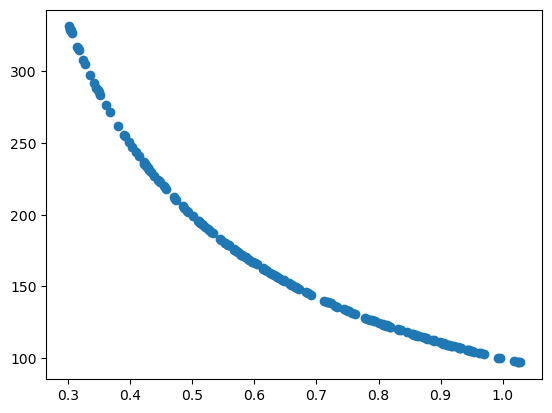

In [58]:
plt.plot(x_train[:,1],y_train[:,0],'o')

In [13]:
y_train

tensor([[296.1940, 106.6400],
        [170.7960, 140.4090],
        [ 63.1401, 122.1590],
        [148.6480,  92.1577],
        [133.1920, 101.1890],
        [132.5730,  91.6085],
        [ 93.5819, 177.4280],
        [106.4450, 133.8390],
        [ 69.9348, 101.1370],
        [ 76.8217, 143.0310],
        [109.8770, 109.3990],
        [176.8380, 143.9360],
        [ 78.2424, 130.4050],
        [ 97.4448, 176.8830],
        [ 93.6578, 122.3940],
        [159.2310,  95.8223],
        [143.1260,  90.5206],
        [103.9100, 111.5330],
        [187.0040, 224.7750],
        [ 96.0024,  89.7075],
        [ 70.5650, 100.6570],
        [ 77.6447, 144.4530],
        [287.4870, 162.1430],
        [156.4700, 157.4960],
        [ 70.4692, 126.2010],
        [248.6590, 130.6360],
        [ 93.2842, 175.0540],
        [ 64.6096, 112.3900],
        [111.5360,  99.6606],
        [110.0210, 159.6500],
        [110.1640, 112.7550],
        [175.0150, 118.9460],
        [ 85.6613,  94.4889],
        [1

In [14]:
x_train.shape

torch.Size([120, 2])

In [15]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1


In [16]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.382351, 0.799717]
[0.300623, 1.02851]


In [17]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_3509/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [18]:
data1.shape

torch.Size([6144, 2])

In [19]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

            ST   ST_conf
CV_V  0.000216  0.000028
CV_A  0.999594  0.053435
            S1   S1_conf
CV_V  0.000177  0.001131
CV_A  0.999603  0.076417
                    S2   S2_conf
[CV_V, CV_A]  0.000041  0.002531
            ST   ST_conf
CV_V  0.999866  0.070610
CV_A  0.000415  0.000052
            S1   S1_conf
CV_V  0.999767  0.079816
CV_A  0.000299  0.001742
                    S2   S2_conf
[CV_V, CV_A]  0.000112  0.077244


In [20]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [21]:
y_all.columns.tolist()

['A_TAT', 'V_TAT']

In [22]:
['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

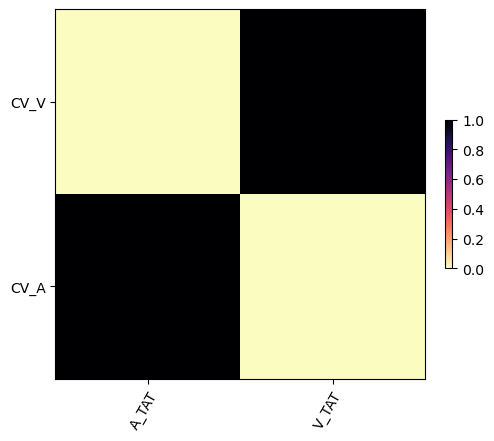

In [23]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

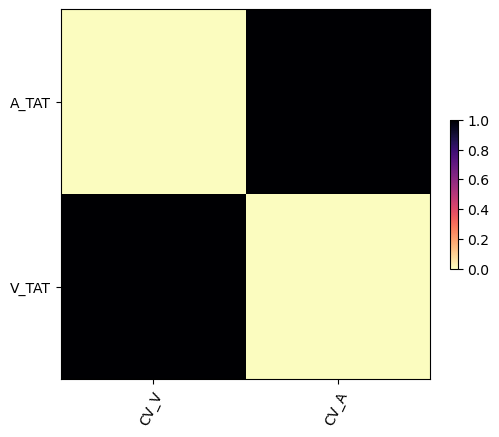

In [24]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [25]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [26]:
boundsMaxMin

[[0.382351, 0.799717], [0.300623, 1.02851]]

In [27]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [28]:
def log_likelihood(x,emulator,y_val,obs_error):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],obs_error)).detach().numpy())
    return ll

In [29]:
def log_prob(theta, emulator,y_val,obs_error):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta,emulator, y_val,obs_error)

In [30]:
import emcee

In [31]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 8
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
obs_error=((y_val*0.05))**2

In [32]:
y_val+2*((y_val*0.05))

tensor([147.4000, 147.4000])

In [33]:
y_val*0.18

tensor([24.1200, 24.1200])

In [34]:
obs_error

tensor([44.8900, 44.8900])

In [35]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val,obs_error])

sampler.run_mcmc(p0, 40000,progress=True)

State([[0.54174924 0.69324879]
 [0.46581124 0.4482903 ]
 [0.50150548 0.59603107]
 [0.51787169 0.51851664]
 [0.45032658 0.6275784 ]
 [0.61596022 0.60892292]
 [0.56929028 0.57839867]
 [0.49404375 0.48494912]], log_prob=[ -8.17564583 -10.50879574  -7.94029713  -8.16339016  -8.92914391
  -8.02775574  -7.71399355  -8.9089756 ], blobs=None, random_state=('MT19937', array([2592128045,  678819370, 1819754377,  942772739, 3140172080,
       2339116405, 3142373280, 1311336537, 1420659059, 3803545524,
       2967269908, 3040997669, 4049119233, 1248794059,  386845585,
       2013531158, 3568732103, 1269719358, 3589956726, 3645196396,
       1466697230, 2378699166, 3915621571, 4283764595,  794932810,
       2408701382, 3240385589, 2563318544, 2878133556, 4148350051,
       1574012905, 1969720867, 3892779758, 3440348358, 3505658910,
       1295743448, 2909398571, 1344372714, 2965694345, 1622710600,
        515846848,  156326210,  258596327, 2313299871, 3975926142,
        619341487, 1272631855,  511

In [36]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

(16000, 2)


In [37]:
boundsMaxMin

[[0.382351, 0.799717], [0.300623, 1.02851]]

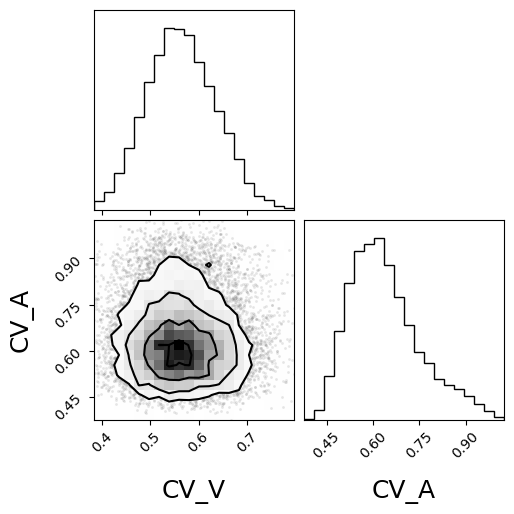

In [38]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels, label_kwargs=dict(fontsize=18)
);

(array([  96., 1126., 2699., 3249., 4075., 3093., 1247.,  339.,   69.,
           7.]),
 array([ 66.0148468 ,  80.85463715,  95.69442749, 110.53421783,
        125.37400818, 140.21380615, 155.05358887, 169.89337158,
        184.73316956, 199.57296753, 214.41275024]),
 <BarContainer object of 10 artists>)

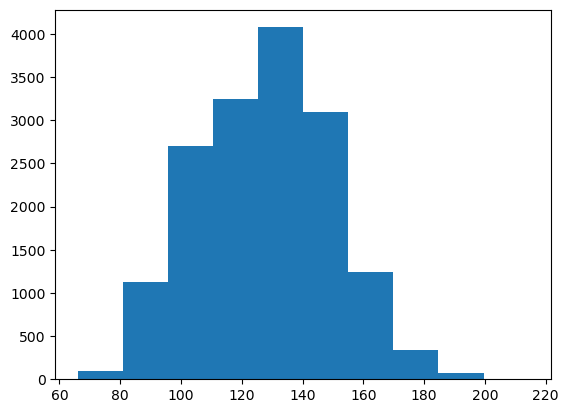

In [39]:
plt.hist(emulator.predict(torch.tensor(flat_samples)).detach().numpy()[:,0])

In [40]:
emulator.predict(torch.tensor(flat_samples)).mean(axis=0)

tensor([127.6346, 132.9164], grad_fn=<MeanBackward1>)

In [41]:
emulator.predict(torch.tensor(flat_samples)).std(axis=0)

tensor([21.9088, 15.0483], grad_fn=<StdBackward0>)

In [42]:
y_val*0.05

tensor([6.7000, 6.7000])

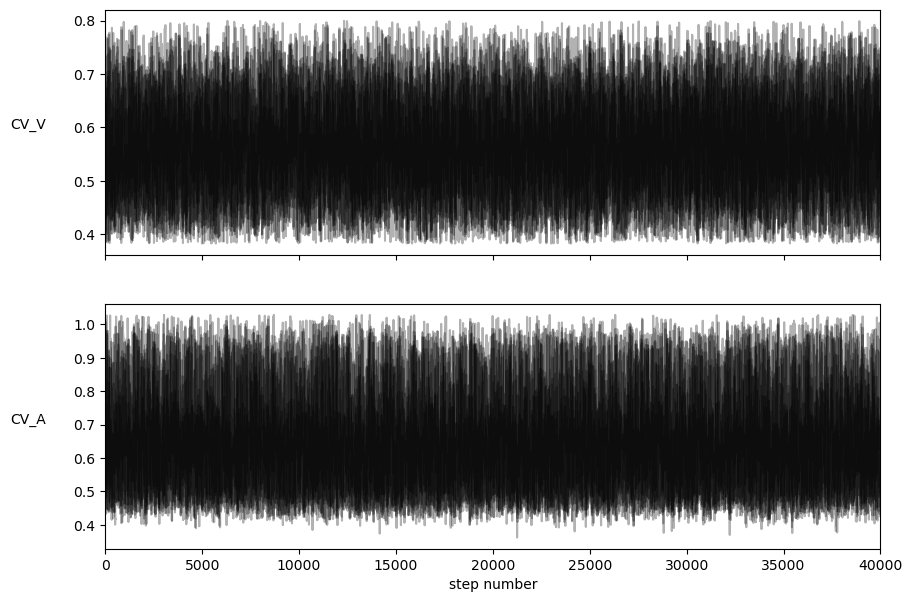

In [43]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [44]:
y_all.min()

A_TAT    63.1401
V_TAT    78.9568
dtype: float64

In [45]:
flat_samples.mean(axis=0)-flat_samples.std(axis=0)

array([0.4940362 , 0.52422764])

In [46]:
flat_samples.mean(axis=0)+flat_samples.std(axis=0)

array([0.63540412, 0.75508513])

In [47]:
boundsMaxMin

[[0.382351, 0.799717], [0.300623, 1.02851]]

In [48]:
emulator.predict(torch.tensor(flat_samples.mean(axis=0))[None])

tensor([[124.4521, 133.7892]], grad_fn=<PermuteBackward0>)